In [1]:
import importlib.metadata
import pathlib
from anywidget import AnyWidget
from traitlets import Unicode, Float, Int, Bool, link
import traitlets
from astrocut import FITSCutout
from astropy.coordinates import SkyCoord 
from astropy.wcs import WCS
from astropy.io import fits
from astropy.io.fits import getheader
from astropy.time import Time
import matplotlib.pyplot as plt 
import ipywidgets as widgets
import numpy as np
from IPython.display import display, HTML
from ipywidgets import Output
from ipywidgets import GridspecLayout
from ipywidgets import VBox, HBox
import warnings

try:
    __version__ = importlib.metadata.version("snipy")
except importlib.metadata.PackageNotFoundError:
    __version__ = "unknown"


class SnipPyFits(AnyWidget):
    """SnipPy widget
    This widget is that displays astronomical images and allowing you to visualize your cutouts in an interactive way.
    Bundles all sub-widgets in the UI
    """
    
    _esm = "./sharedwidget_V1.js"
    _css = "./sharedwidget_V1.css"
    class Coordinates(AnyWidget):
        
        """Widget responsible for ra and dec"""
        
        component = Unicode("Coordinates").tag(sync=True)
        _esm = "./sharedwidget_V1.js"
        _css = "./sharedwidget_V1.css"
        ra = traitlets.Float().tag(sync=True)
        dec = traitlets.Float().tag(sync=True)

        
    class Ratio(AnyWidget):
        
        """Widget responsible for the Zoom and Crop size"""
        
        component = Unicode("Ratio").tag(sync=True)
        _esm = "./sharedwidget_V1.js"
        _css = "./sharedwidget_V1.css"
        cropwidth = traitlets.Float().tag(sync=True)
        cropheight = traitlets.Float().tag(sync=True)

        
    class Normalization(AnyWidget):
        
        """Widget responsible for Stretch, Min/Max Percent, and Invert"""
        
        component = Unicode("Normalization").tag(sync=True)
        _esm = "./sharedwidget_V1.js"
        _css = "./sharedwidget_V1.css"

        min_percent = traitlets.Float(10.0).tag(sync=True)
        max_percent = traitlets.Float(99.0).tag(sync=True)
        invert = traitlets.Bool(False).tag(sync=True)
        invertbut = traitlets.Bool(False).tag(sync=True)
        total = traitlets.Int(1).tag(sync=True)
        stretch = traitlets.Unicode("linear").tag(sync=True)
        preview_color = traitlets.Bool(False).tag(sync=True)

        
    class Save(AnyWidget):
        
        """Widget responsible for the saving features (Memory, FITS, PNG, and Colorized PNG"""
        
        component = Unicode("Save").tag(sync=True)
        _esm = "./sharedwidget_V1.js"
        _css = "./sharedwidget_V1.css"
        save_fits = traitlets.Bool(False).tag(sync=True)
        save_png = traitlets.Bool(False).tag(sync=True)
        save_color = traitlets.Bool(False).tag(sync=True)
        total = traitlets.Int(1).tag(sync=True)
        save_memory = traitlets.Bool(False).tag(sync=True)
        
    class ImageCounter(AnyWidget):
         
        """Widget responsible for Flipping between images and inticating which it being viewed"""
        
        component = Unicode("ImageCounter").tag(sync=True)
        _esm = "./sharedwidget_V1.js"
        _css = "./sharedwidget_V1.css"
        index = traitlets.Int(0).tag(sync=True)
        total = traitlets.Int(1).tag(sync=True)

    def __init__(self, input_files):
        super().__init__()
        self.input_files = input_files
        
        hdulist = fits.open(input_files[0])
        img_hdu = next(h for h in hdulist if h.data is not None and h.data.ndim == 2)

        header = self.ensure_mjd_obs(img_hdu.header.copy())
        data = img_hdu.data
        naxis2, naxis1 = data.shape
        wcs = self.smart_wcs_from_header(header)


        """Initial calculations to get starting coordinates and size"""
        ra_min, dec_min = wcs.wcs_pix2world(0, 0, 0)
        ra_max, dec_max = wcs.wcs_pix2world(naxis1, naxis2, 0)
        mid_ra = ra_max - ((ra_max - ra_min)/2)
        mid_dec = dec_max - ((dec_max - dec_min)/2)

        """Names widgets as varibles to be recalled through the code"""
        self.TOP = self.Coordinates()
        self.LEFT = self.Ratio()
        self.RIGHT = self.Normalization()
        self.SAVE = self.Save()
        self.BOTTOM = self.ImageCounter()
        self.ShowImage = Output()
        self.BOTTOM.total = len(input_files)
        self.SAVE.total = len(input_files)
        
        """Defines the starting conditions for the input files"""
        self.TOP.ra = mid_ra
        self.TOP.dec = mid_dec
        self.LEFT.cropwidth = naxis1
        self.LEFT.cropheight = naxis2
        self.cutout = self.saveMemory()

        """Watches for changes in widegt, if change Updates Image"""
        for name in ['ra',
                     'dec']:
            self.TOP.observe(self.Run_image, names=name)
    
        for name in ['cropwidth',
                     'cropheight']:
            self.LEFT.observe(self.Run_image, names=name)
        for name in ['min_percent',
                     'max_percent',
                     'invertbut',
                     'stretch']:
            self.RIGHT.observe(self.Run_image, names=name)
        for name in ['index']:
            self.BOTTOM.observe(self.Run_image, names=name)

        """Watched for button pressed, if pressed will run function"""    
        self.SAVE.observe(self.saveFITS, names="save_fits")
        self.SAVE.observe(self.savePNG, names="save_png")
        self.SAVE.observe(self.saveColor, names="save_color") 
        self.SAVE.observe(self.saveMemory, names="save_memory")

        
        """Formats the Widgets' Layout"""
        self.Run_image()
        AppLayout = HBox([VBox([self.ShowImage,self.BOTTOM]), VBox([self.TOP,self.LEFT, self.RIGHT, self.SAVE])])
        self.widget = VBox([AppLayout])
        self.widget.add_class("Background")



    
    def ensure_mjd_obs(self, header):
        """Add MJD-OBS if it is missing but DATE-OBS is present."""
        if 'DATE-OBS' in header and 'MJD-OBS' not in header:
            try:
                header['MJD-OBS'] = Time(header['DATE-OBS'], format='isot').mjd
                
            except Exception:
                pass
        return header
    
    def smart_wcs_from_header(self, header):
        hdr = header.copy()                       
        has_sip = any(k in hdr for k in ['A_ORDER', 'B_ORDER'])
        sip_ok   = '-SIP' in hdr.get('CTYPE1', '') or '-SIP' in hdr.get('CTYPE2', '')
        if has_sip:
            if not sip_ok:
                for key in ('CTYPE1', 'CTYPE2'):
                    if key in hdr and '-SIP' not in hdr[key]:
                        hdr[key] = hdr[key].strip() + '-SIP'
            wcs = WCS(hdr)                          
        else:
            sip_keys = [k for k in hdr
                        if k.startswith(('A_', 'B_', 'AP_', 'BP_')) or
                           k in ('A_ORDER', 'B_ORDER', 'A_DMAX', 'B_DMAX')]
            for k in sip_keys:
                hdr.remove(k, ignore_missing=True, remove_all=True)
            wcs = WCS(hdr)
        return wcs

    def Run_image(self, change=None):
        """Function responsible for Updating the displayed image"""
        with self.ShowImage:
            try:
                #Uses current parameters for astrocut functions
                center_coord = SkyCoord(self.TOP.ra, self.TOP.dec, unit="deg")
                cutout_size = [self.LEFT.cropwidth, self.LEFT.cropheight]
                #Ignore warning messages that occur
                    #if image is not perfectly filled in crop area
                    #if the WCS needed to be converted
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    warnings.filterwarnings("ignore", category=Warning, module="astropy.wcs")
                      #Functions from Astrocut
                    fits_cutout = FITSCutout(
                        input_files=self.input_files,
                        coordinates=center_coord,
                        cutout_size=cutout_size,
                        single_outfile=True)

                    cutouts = fits_cutout.get_image_cutouts(
                        stretch=self.RIGHT.stretch,
                        invert=self.RIGHT.invertbut,
                        minmax_percent=[self.RIGHT.min_percent, self.RIGHT.max_percent])
                    
                    self.cutout = fits_cutout.fits_cutouts[0]
        
                    fits_img = cutouts[self.BOTTOM.index]
    
                    self.ShowImage.clear_output(wait=True)
        
                    fig, ax = plt.subplots(figsize=(5, 5), dpi=100, facecolor='#000f14')

                    """Display the image"""
                    ax.imshow(fits_img, cmap='gray', origin='upper')
                    ax.set_xticks([])
                    ax.set_yticks([])
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_color('#ffffff')
                        spine.set_linewidth(1)
                    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
                    
                    plt.show()

            except:
                pass



    
    """Saves the displayed cutouts as  FITS files to parent directory"""
    def saveFITS(self, change):
            try:
                center_coord = SkyCoord(self.TOP.ra, self.TOP.dec, unit="deg")
                cutout_size = [self.LEFT.cropwidth, self.LEFT.cropheight]
    
                fits_cutout = FITSCutout(
                                input_files=self.input_files,
                                coordinates=center_coord,
                                cutout_size=cutout_size,
                                single_outfile=False)
                fits_cutout.write_as_fits()
            except:
                pass
            finally:
                self.SAVE.save_fits = False

    
    
    
    
    
    """Saves the displayed cutouts as a PNGs to parent directory"""
    def savePNG(self, change):
        try:
            center_coord = SkyCoord(self.TOP.ra, self.TOP.dec, unit="deg")
            cutout_size = [self.LEFT.cropwidth, self.LEFT.cropheight]
            fits_cutout = FITSCutout(
                            input_files=self.input_files,
                            coordinates=center_coord,
                            cutout_size=cutout_size,
                            single_outfile=True)
            fits_cutout.write_as_img(
                        stretch=self.RIGHT.stretch,
                        invert=self.RIGHT.invertbut,
                        minmax_percent=[self.RIGHT.min_percent, self.RIGHT.max_percent],
                        output_format='png')
        except Exception:
            pass
        finally:
            self.SAVE.save_png = False
    




    """Saves the displayed cutout and combines three fits in a R,G,B filter as a PNG to parent directory"""
    def saveColor(self, change):
        try:
            center_coord = SkyCoord(self.TOP.ra, self.TOP.dec, unit="deg")
            cutout_size = [self.LEFT.cropwidth, self.LEFT.cropheight]
            fits_cutout = FITSCutout(
                            input_files=self.input_files,
                            coordinates=center_coord,
                            cutout_size=cutout_size,
                            single_outfile=False)
            fits_cutout.write_as_img(
                        stretch=self.RIGHT.stretch,
                        invert=self.RIGHT.invertbut,
                        minmax_percent=[self.RIGHT.min_percent, self.RIGHT.max_percent],
                        colorize=True,
                        output_format='png')
        except Exception:
            pass
        finally:
            self.SAVE.save_color = False





    # """saves cutout to memory for uses in notebook"""
    # def saveMemory(self, change=None):
    #     try:
    #             center_coord = SkyCoord(self.TOP.ra, self.TOP.dec, unit="deg")
    #             cutout_size = [self.LEFT.cropwidth, self.LEFT.cropheight]
    #             fits_cutout = FITSCutout(
    #                             input_files=self.input_files,
    #                             coordinates=center_coord,
    #                             cutout_size=cutout_size,
    #                             single_outfile=True)
    #             self.cutout = fits_cutout.fits_cutouts[0]
    #     except Exception:
    #         self.cutout = None
    #     finally:
    #         self.SAVE.save_memory = False
    #     return self.cutout

        
    def _ipython_display_(self, **kwargs):
        container = HTML("<style>.Background > .widget-box { background-color: #000f14; padding: 25px; }</style>")
        display(container, self.widget)


snip = SnipPyFits(["https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=J8UP02USQ%2Fj8up02usq_drz.fits",
            "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=J8UP02UTQ%2Fj8up02utq_drz.fits",
            "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=J8UP02UUQ%2Fj8up02uuq_drz.fits"
           ])
snip

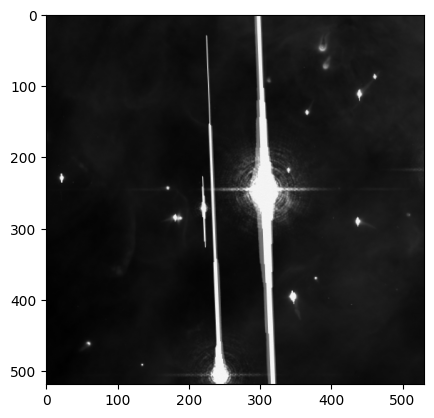

In [3]:
image_data = snip.cutout[1].data
plt.imshow(image_data, cmap="gray")